In [1]:
import numpy as np
import pandas as pd
from PyEMD import EMD, Visualisation
import scipy
import math
from sklearn import metrics

import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import ipdb

# 1. TCA function defining

In [2]:
def var_name(var, all_var=locals()):
    # get the name of the variable
    return [var_name for var_name in all_var if all_var[var_name] is var][0]


def np2csv(A):
    # store numpy to local csv file
    if type(A) == torch.Tensor:
        np.savetxt(var_name(A)+'.csv', A.detach().numpy(), delimiter=',')
    elif type(A) == np.ndarray:
        np.savetxt(var_name(A)+'.csv', A, delimiter=',')


def flat2vec(df):
    # df contains index and column tags
    # function: flatten a df (has 2 dimensions) to a 1D vector
    # the df data properties:
    # [[d1t1 d1t2 d1t3]
    #  [d2t1 d2t2 d2t3]
    #  [d3t1 d3t2 d3t3]]
    # dntn means day n time n
    
    # returned vector: 1D
    return np.array(df.loc[1:, 1:96].astype(float)).reshape(-1, 1).flatten()


def normalize(V):
    return ( V - min(V.flatten()) ) / ( max(V.flatten()) - min(V.flatten()) )

In [3]:
def sliding_window(T, T_org, seq_len, label_seq_len):

    # seq_len is equal to window_size
    # T (np.array) has dim: population, seq_len (window length)
    TT = T.reshape(-1, 1)
    K = TT.shape[0] - seq_len - label_seq_len + 1  # Li, et al., 2021, TRJ part C, pp. 8
    
    TT_org = T_org.reshape(-1, 1)

    # TT has dim: n, 1
    # assemble the data into 2D
    x_set = np.vstack(TT[i : K+i, 0] for i in range(seq_len)).T
    y_set = np.vstack(TT_org[i+seq_len : K+seq_len+i, 0] for i in range(label_seq_len)).T
    
    assert x_set.shape[0] == y_set.shape[0]

    # return size: [sequence_len, batch_size, inp/out dim = 1(default)]
    return x_set.T, y_set.T



In [4]:
def kernel(ker, X1, X2, gamma):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        if X2 is not None:
            # next line: K = X1.T@X2
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = X1.T@X1
    elif ker == 'rbf':
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
    return K

In [5]:
class TCA:
    def __init__(self, kernel_type='primal', dim=30, lamb=1, gamma=1):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.dim = dim
        self.lamb = lamb
        self.gamma = gamma

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        L = e * e.T
        L = L / np.linalg.norm(L, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))  # page 202
        K = kernel(self.kernel_type, X, None, gamma=self.gamma)
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, L, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new, Xt_new, A

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        clf = KNeighborsClassifier(n_neighbors=1)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        return acc, y_pred, Xs_new, Xt_new

**$X_{S, n_s\times n_{feature}}$**

**$X_{T, n_t\times n_{feature}}$**

**$X_{S, n_s\times n_{feature}}$** = **$((A^T)_{n_{feature}\times(n_s+n_t)}K_{(n_s+n_t)\times(n_s+n_t)})^T$**[:ns, :]

# 2. Learning Part

## 2.a. Load Data

In [6]:
weekdays = np.vstack([np.array([np.arange(2+7*i,7+7*i,1) for i in range(2)]), \
                      np.array([np.arange(15+7*i,20+7*i,1) for i in range(2)])]).flatten()

src_domain = np.array(pd.read_csv('data/siteM4_2210B_20210101_20210131.csv'))[weekdays, :]  # upstream
data_target = np.array(pd.read_csv('data/siteM4_2168B_20210101_20210131.csv'))  # downstream

date_choosen = 3
tar_domain = data_target[weekdays[date_choosen], :].reshape(-1, 96)
tgt_validation = data_target[weekdays[date_choosen+1:date_choosen+1 + 5], :].reshape(-1, 96)

### 2.a.i. preview data

Text(0.5,1,'Train Set')

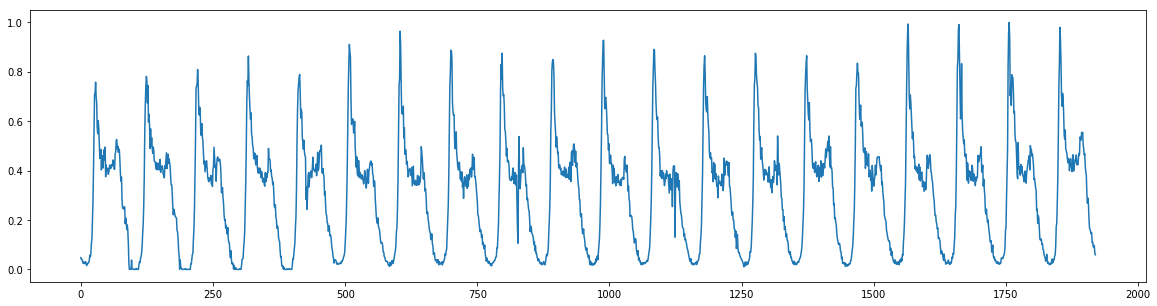

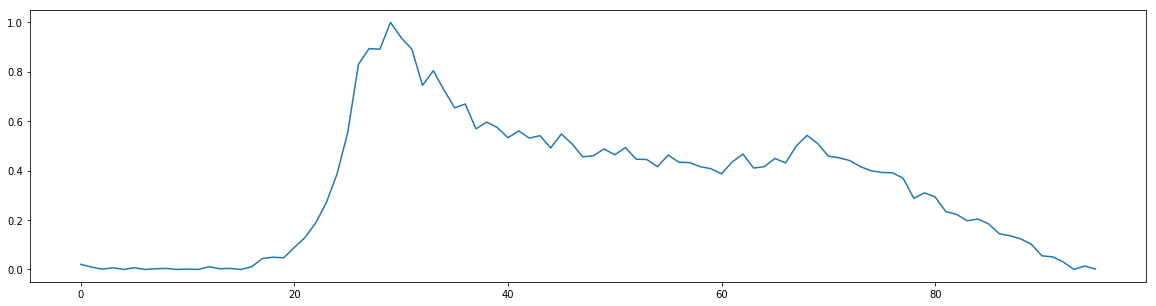

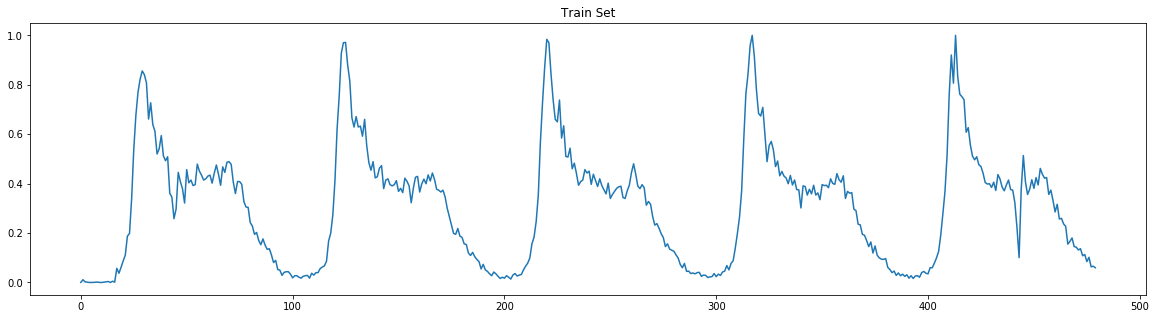

In [7]:
src_domain_emd = normalize(src_domain.flatten())
plt.figure(figsize=(20,5))
plt.plot(src_domain_emd)
tar_domain_emd = normalize(tar_domain.flatten())
plt.figure(figsize=(20,5))
plt.plot(tar_domain_emd)
tgt_validation_emd = normalize(tgt_validation.flatten())
plt.figure(figsize=(20,5))
plt.plot(tgt_validation_emd)
plt.title('Train Set')

## 2.b. Extract Features using EMD

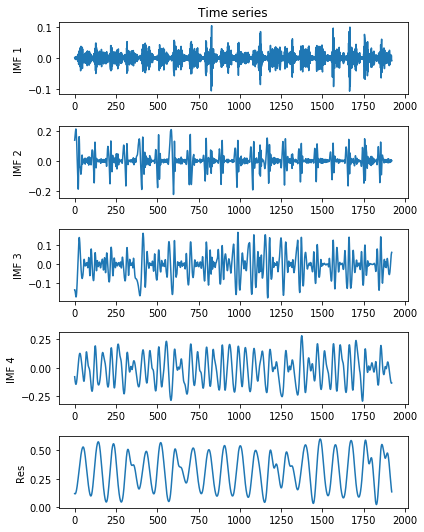

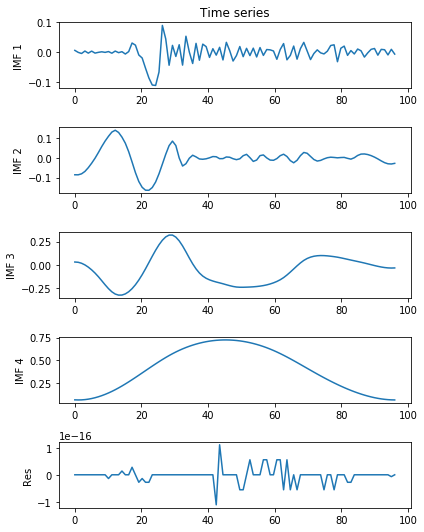

In [8]:
max_imf = 4

emd = EMD()
emd.emd(src_domain_emd, max_imf=max_imf)
imfs_src, res_src = emd.get_imfs_and_residue()
vis = Visualisation()
t_src = np.linspace(0, src_domain_emd.shape[0], src_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_src, residue=res_src, t=t_src, include_residue=True)
vis.show()

emd = EMD()
emd.emd(tar_domain_emd, max_imf=max_imf)
imfs_tar, res_tar = emd.get_imfs_and_residue()
vis = Visualisation()
t_tar = np.linspace(0, tar_domain_emd.shape[0], tar_domain_emd.shape[0])
vis.plot_imfs(imfs=imfs_tar, residue=res_tar, t=t_tar, include_residue=True)
vis.show()



In [9]:
tgt_validation_emd.shape

(480,)

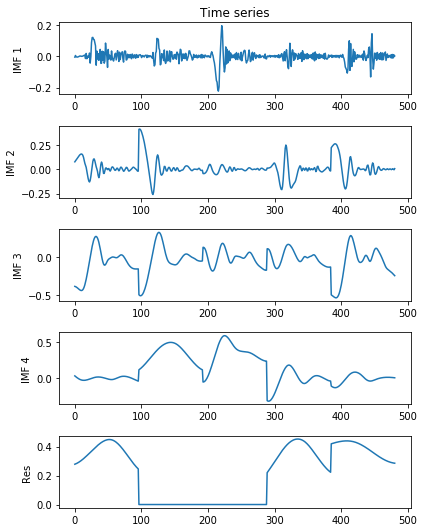

In [10]:

imfs_tar_valid = np.zeros([max_imf, tgt_validation_emd.shape[0]])
res_tar_valid = np.zeros([tgt_validation_emd.shape[0]])

for i in range(int(tgt_validation_emd.shape[0]/96)):
    emd = EMD()
    emd.emd(tgt_validation_emd[96*i:96*(i+1)], max_imf=max_imf)
    imfs_tar_valid_i, res_tar_valid_i = emd.get_imfs_and_residue()
    
    imfs_tar_valid[:, 96*i:96*(i+1)] += imfs_tar_valid_i
    res_tar_valid[96*i:96*(i+1)] += res_tar_valid_i

vis = Visualisation()
t_tar_valid = np.linspace(0, tgt_validation_emd.shape[0], tgt_validation_emd.shape[0])
vis.plot_imfs(imfs=imfs_tar_valid, residue=res_tar_valid, t=t_tar_valid, include_residue=True)
vis.show()



### 2.b.i. assemble Xs and Xt

Data type of **Xs**: [normalized_raw_data (fisrt row); emd_results (rest rows)]

In [11]:
Xs = np.concatenate([src_domain_emd.reshape(1, -1), imfs_src, res_src.reshape(1, -1)])
Xt = np.concatenate([tar_domain_emd.reshape(1, -1), imfs_tar, res_tar.reshape(1, -1)])
Xt_valid = np.concatenate([tgt_validation_emd.reshape(1, -1), imfs_tar_valid, res_tar_valid.reshape(1, -1)])

In [12]:
print(Xt.shape, Xs.shape)

(6, 96) (6, 1920)


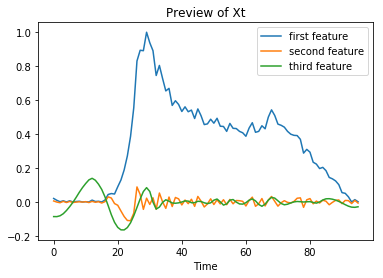

In [13]:
plt.plot(Xt[0, :], label='first feature')
plt.plot(Xt[1, :], label='second feature')
plt.plot(Xt[2, :], label='third feature')
plt.title('Preview of Xt')
plt.xlabel('Time')
plt.legend()

## 2.c. Hyperparameters

In [14]:
inp_dim = Xs.shape[0]
label_dim = Xs.shape[0]
label_seq_len = 1
# batch_size = full batch
seq_len = 10
reduced_dim = 1
hid_dim = 16
layers = 3
lamb = 3

hyper = {
    'inp_dim':inp_dim,
    'label_dim':label_dim,
    'label_seq_len':label_seq_len,
    'seq_len':seq_len,
    'reduced_dim':reduced_dim,
    'hid_dim':hid_dim,
    'layers':layers,
    'lamb':lamb}
hyper = pd.DataFrame(hyper, index=['Values'])

## 2.d. Apply Domain Adaptation using TCA (see part 1) upon Xs and Xt

In [15]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,6,6,1,10,1,16,3,3


In [16]:
def get_data_in_feature_space(Xs, Xt, A):
    # Xs and Xt have dim: n_feature, n
    # A has dimension: ns+nt, n_feature
    feature_dim = A.shape[1]
    Xt_new_fea = np.zeros([feature_dim, Xt.shape[1]])
    
    for i in range(int(Xt.shape[1]/96)):
        #ipdb.set_trace()
        Xt_i = Xt[:, 96*i:96*(i+1)]
        X = np.hstack([Xs, Xt_i])
        X /= np.linalg.norm(X, axis=0)


        As = A[:Xs.shape[1], :]
        At = A[Xs.shape[1]:, :]
        Qs = X[:, :Xs.shape[1]]
        Qt = X[:, Xs.shape[1]:]

        Xt_new_fea_i = As.T @ Qs.T @ Qt + At.T @ Qt.T @ Qt
        Xt_new_fea_i /= np.linalg.norm(Xt_new_fea_i, axis=0)
    
        Xt_new_fea[:, 96*i:96*(i+1)] += Xt_new_fea_i
        
    '''
    X = np.hstack([Xs, Xt])
    X /= np.linalg.norm(X, axis=0)
    K = kernel('linear', X, None, gamma=None)
    Z = A.T @ K
    Z /= np.linalg.norm(Z, axis=0)
    Xs_new_fea = Z[:, :Xs.shape[1]]
    Xt_new_fea = Z[:, Xs.shape[1]:]
    '''
    
    return Xt_new_fea

In [17]:
inp_dim -= reduced_dim
label_dim -= reduced_dim

tca = TCA(kernel_type='linear', dim=inp_dim, lamb=lamb, gamma=1)
Xs_new, Xt_new, A = tca.fit(Xs.T, Xt.T)  # input shape: ns, n_feature
Xs_new, Xt_new = Xs_new.T, Xt_new.T
Xt_valid_new = get_data_in_feature_space(Xs, Xt_valid, A)

print(Xs_new.shape)
print(Xt_new.shape)

np2csv(Xt_valid_new)
np2csv(Xt_new)

(5, 1920)
(5, 96)


## 2.e. The LSTM network, hyperparameters see part 2.a.

In [18]:
class LSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, hid_dim, layers):
        super(LSTM, self).__init__()

        self.out_dim = out_dim
        
        self.lstm = nn.LSTM(inp_dim, hid_dim, layers, dropout=0.1)
        
        self.fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim)
        )  # regression
    
    def forward(self, x):
        # input: (seq_len, batchsize, input_dim)
        # output: (seq_len, batchsize, hid_dim)
        #ipdb.set_trace()
        y = self.lstm(x)[0]  # y, (h, c) = self.rnn(x)
        
        y = self.fc(y)  # fully connected layer
        
        return y[-1, :, :]



In [19]:
def assemble(X):
    '''
    X = torch.tensor(X)
    batch_num = X.shape[0] // (seq_len*batch_size)
    new_X = torch.zeros(seq_len, batch_size, dim, batch_num)
    for i in range(batch_num):
        for j in range(batch_size):
            #ipdb.set_trace()
            new_X[:, j, :, i] = X[seq_len*(i*j+j):seq_len*(i*j+j+1), :]
    '''
    new_X = X[:, :, np.newaxis]
    return new_X

## 2.e.i. assemble data and build model

Note: **Xs** is the result of EMD, and is designated for TCA to generate **Xs_new**

**src_domain** and **tar_domain** are the raw data sets



In [20]:
def dataloader(Xs_new, Xt_new, Xs, Xt, seq_len, label_seq_len, inp_dim, label_dim):
    batch_size = Xs_new.shape[1] + Xt_new.shape[1] + 2 * (- seq_len - label_seq_len + 1)
    train_x = np.zeros([ seq_len, batch_size, inp_dim ])  # seq_len, batch_size, inp_dim
    train_y = np.zeros([ label_seq_len, batch_size, label_dim ])

    for i in range(inp_dim):
        x_i_src, y_i_src = sliding_window(Xs_new[i, :], Xs[i, :], seq_len, label_seq_len)  # i means i^th dim
        x_i_tar, y_i_tar = sliding_window(Xt_new[i, :], Xt[i, :], seq_len, label_seq_len)  # i means i^th dim

        train_x[:, :, i] += np.concatenate([x_i_src, x_i_tar], axis=1)
        train_y[:, :, i] += np.concatenate([y_i_src, y_i_tar], axis=1)
        
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_x = torch.tensor(train_x, dtype=torch.float32, device=device)
    train_y = torch.tensor(train_y, dtype=torch.float32, device=device)
        
    return train_x, train_y

In [35]:
hyper

,inp_dim,label_dim,label_seq_len,seq_len,reduced_dim,hid_dim,layers,lamb
Values,6,6,1,10,1,16,3,3


In [45]:
train_x, train_y = dataloader(Xs_new, Xt_new, Xs, Xt, seq_len, label_seq_len, inp_dim, label_dim)

# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = LSTM(inp_dim, label_dim, hid_dim=8, layers=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


## 2.e.ii. train

In [46]:
# train
num_epoch = 10001

for e in range(num_epoch):
    # train_x: [seq_len, batch_size, inp_dim, batch#]
    #ipdb.set_trace()
    out = net(train_x)

    weight = torch.tensor(normalize(np.array([5,4,3,2,1])).reshape(-1, 1), dtype=torch.float32).to(device)
    loss = (out - train_y[0, :, :]) ** 2 @ weight
    #loss = torch.sum(torch.abs(train_y[0, :, :] - out)) / torch.sum(train_y[0, :, :] + out)
    
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    
    if e%1000==0:
        print('Epoch: {:4}, Loss: {:.7f}'.format(e, loss.item()))
        #scheduler.step()
        

Epoch:    0, Loss: 0.1776362
Epoch: 1000, Loss: 0.0125059
Epoch: 2000, Loss: 0.0087387
Epoch: 3000, Loss: 0.0071972
Epoch: 4000, Loss: 0.0065052
Epoch: 5000, Loss: 0.0055691
Epoch: 6000, Loss: 0.0053132
Epoch: 7000, Loss: 0.0047953
Epoch: 8000, Loss: 0.0045537
Epoch: 9000, Loss: 0.0043544
Epoch: 10000, Loss: 0.0041502


## 2.e.iii. test

In [47]:
def test_dataloader(Xt_valid_temp, Xt, seq_len, label_seq_len, inp_dim, label_dim):
    batch_size = Xt_valid_temp.shape[1] - seq_len - label_seq_len + 1
    test_x_temp = np.zeros([ seq_len, batch_size, inp_dim ])  # seq_len, batch_size, inp_dim
    test_y_temp = np.zeros([ label_seq_len, batch_size, label_dim ])

    for i in range(inp_dim):
        x_i_tar, y_i_tar = sliding_window(Xt_valid_temp[i, :], Xt[i, :], seq_len, label_seq_len)  # i means i^th dim

        test_x_temp[:, :, i] += x_i_tar
        test_y_temp[:, :, i] += y_i_tar
    #ipdb.set_trace()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_x_temp = torch.tensor(test_x_temp, dtype=torch.float32, device=device)
    test_y_temp = torch.tensor(test_y_temp, dtype=torch.float32, device=device)
        
    return test_x_temp, test_y_temp

In [48]:
test_x, test_y = test_dataloader(Xt_valid_new, Xt_valid, seq_len, label_seq_len, inp_dim, label_dim)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


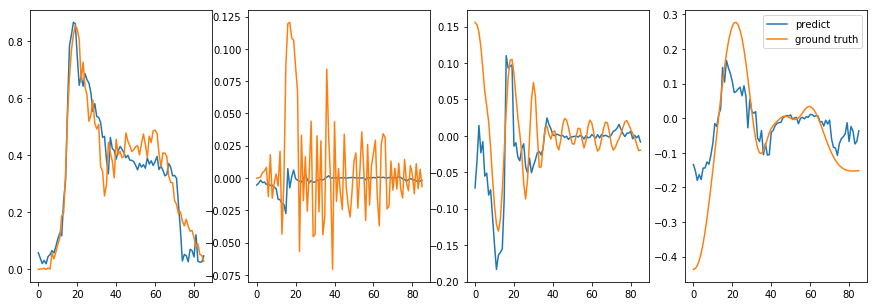

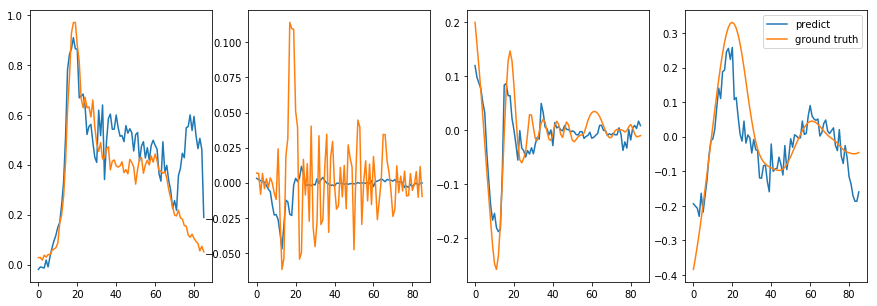

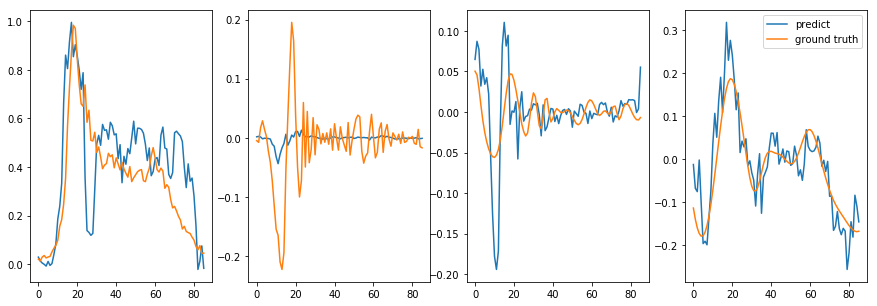

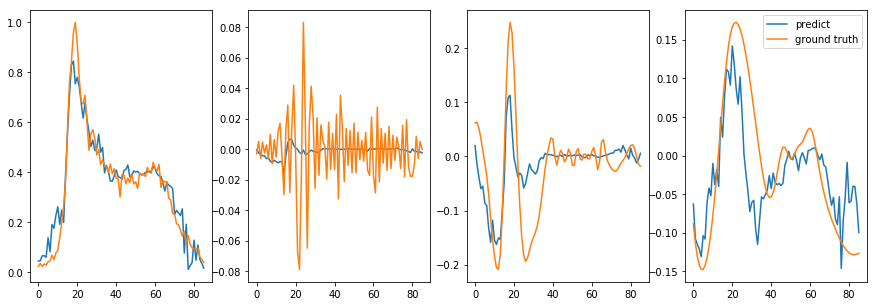

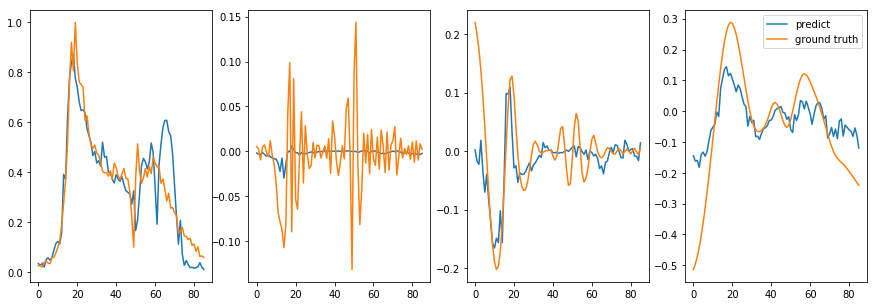

In [49]:
sample_num_per_day = (96 - seq_len - label_seq_len + 1)
num_days = int(Xt_valid.shape[1]/96)
sample_num = sample_num_per_day*num_days

test_x = torch.zeros([seq_len, sample_num, inp_dim]).to(device)
test_y = torch.zeros([label_seq_len, sample_num, inp_dim]).to(device)
pred_y = torch.zeros([sample_num, inp_dim]).to(device)

for i in range(int(Xt_valid.shape[1]/96)):
    test_x_i, test_y_i = test_dataloader(Xt_valid_new[:, 96*i:96*(i+1)], Xt_valid[:, 96*i:96*(i+1)], \
                                       seq_len, label_seq_len, inp_dim, label_dim)
    pred_y_i = net(test_x_i)
    
    test_x[:, sample_num_per_day*i:sample_num_per_day*(i+1)] += test_x_i
    test_y[:, sample_num_per_day*i:sample_num_per_day*(i+1)] += test_y_i
    pred_y[sample_num_per_day*i:sample_num_per_day*(i+1)] += pred_y_i
    
    fig = plt.figure(figsize=[15,5])
    ax = fig.add_subplot(141)
    ax.plot(pred_y_i.cpu().detach().numpy()[:, 0], label='predict')
    ax.plot(test_y_i.cpu().detach().numpy()[0, :, 0], label='ground truth')
    
    ax2 = fig.add_subplot(142)
    ax2.plot(pred_y_i.cpu().detach().numpy()[:, 1], label='predict')
    ax2.plot(test_y_i.cpu().detach().numpy()[0, :, 1], label='ground truth')
    
    ax3 = fig.add_subplot(143)
    ax3.plot(pred_y_i.cpu().detach().numpy()[:, 2], label='predict')
    ax3.plot(test_y_i.cpu().detach().numpy()[0, :,2], label='ground truth')
    
    ax4 = fig.add_subplot(144)
    ax4.plot(pred_y_i.cpu().detach().numpy()[:, 3], label='predict')
    ax4.plot(test_y_i.cpu().detach().numpy()[0, :, 3], label='ground truth')
    
    plt.legend()


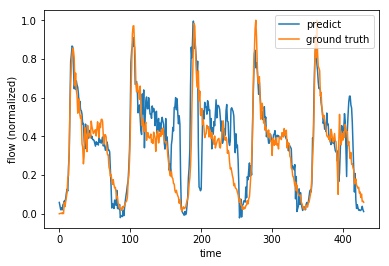

In [50]:
plt.plot(pred_y.cpu().detach().numpy()[:, 0], label='predict')
plt.plot(test_y.cpu().detach().numpy()[0, :, 0], label='ground truth')
plt.xlabel('time')
plt.ylabel('flow (normalized)')
plt.legend()

# 3. Post Analysis, Test

In [51]:
def mape(actual, predict): 
    tmp, n = 0.0, 0
    for i in range(0, len(actual)):
        if actual[i] != 0:
            tmp += math.fabs((actual[i]-predict[i])/(actual[i]+1))
            n += 1
    return (tmp/n)

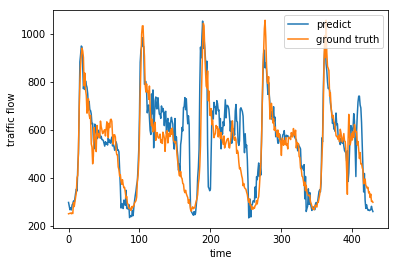

In [52]:
ground_truth_denorm = test_y.cpu()[0, :, 0].detach().numpy()*(max(tgt_validation.flatten()) - min(tgt_validation.flatten())) +np.mean(tgt_validation.flatten())
pred_y_denorm = pred_y.cpu().detach().numpy()[:, 0]*(max(tgt_validation.flatten()) - min(tgt_validation.flatten())) +np.mean(tgt_validation.flatten())

plt.plot(pred_y_denorm, label='predict')
plt.plot(ground_truth_denorm, label='ground truth')
plt.xlabel('time')
plt.ylabel('traffic flow')
plt.legend()

In [53]:
MSE = metrics.mean_squared_error(ground_truth_denorm, pred_y_denorm)
MAE = metrics.mean_absolute_error(ground_truth_denorm, pred_y_denorm)
MAPE = mape(ground_truth_denorm, pred_y_denorm)
SMAPE2 = np.sum(np.abs(ground_truth_denorm - pred_y_denorm)) / np.sum(ground_truth_denorm + pred_y_denorm)
R2 = 1 - np.sum((ground_truth_denorm - pred_y_denorm)**2) / np.sum((ground_truth_denorm - np.mean(ground_truth_denorm))**2)

print("MSE:", MSE)
print("MAE:", MAE)
print("MAPE:", MAPE)
print("SMAPE2:", SMAPE2)
print("R2:", R2)

MSE: 11286.928
MAE: 72.83554
MAPE: 0.15293199584858524
SMAPE2: 0.067096174
R2: 0.655882328748703


# 4. Train Only Use Target Data Set

In [30]:
target_x, target_y = test_dataloader(Xt_new, Xt, seq_len, label_seq_len, inp_dim, label_dim)
target_x = target_x[:, :, 0:1]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  del sys.path[0]


In [31]:
# build model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net2 = LSTM(inp_dim=1, out_dim=1, hid_dim=hid_dim, layers=layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#scheduler =  torch.optim.lr_scheduler.StepLR(optimizer, 0.7)

In [32]:
# train
num_epoch = 1501

for e in range(num_epoch):
    # train_x: [seq_len, batch_size, inp_dim, batch#]
    #ipdb.set_trace()
    out2 = net2(target_x)

    loss = (out2 - target_y[0, :, :]) ** 2
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    
    if e%100==0:
        print('Epoch: {:4}, Loss: {:.7f}'.format(e, loss.item()))
        #scheduler.step()

Epoch:    0, Loss: 0.1224505
Epoch:  100, Loss: 0.1223196
Epoch:  200, Loss: 0.1224234
Epoch:  300, Loss: 0.1224360
Epoch:  400, Loss: 0.1224559
Epoch:  500, Loss: 0.1224251
Epoch:  600, Loss: 0.1224136
Epoch:  700, Loss: 0.1224165
Epoch:  800, Loss: 0.1225663
Epoch:  900, Loss: 0.1224789
Epoch: 1000, Loss: 0.1224573
Epoch: 1100, Loss: 0.1224108
Epoch: 1200, Loss: 0.1224589
Epoch: 1300, Loss: 0.1224239
Epoch: 1400, Loss: 0.1224524
Epoch: 1500, Loss: 0.1224680


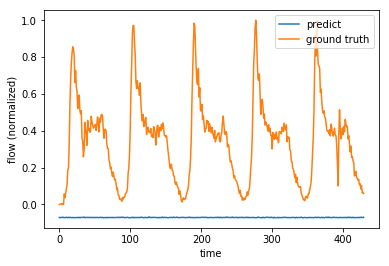

In [33]:
pred_y2 = net2(test_x[:, :, 0:1])
plt.plot(pred_y2.cpu().detach().numpy()[:, 0], label='predict')
plt.plot(test_y.cpu().detach().numpy()[0, :, 0], label='ground truth')
plt.xlabel('time')
plt.ylabel('flow (normalized)')
plt.legend()

MSE: 117843.164
MAE: 302.02664
MAPE: 0.5596368189010462
SMAPE2: 0.43584082
R2: -3.428252696990967


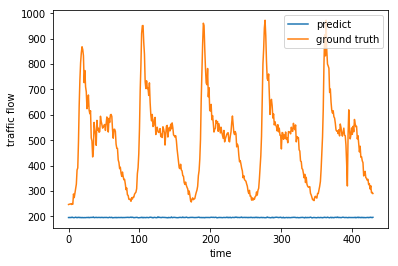

In [34]:
ground_truth_denorm2 = test_y.cpu()[0, :, 0].detach().numpy()*(max(tar_domain.flatten()) - min(tar_domain.flatten())) +np.mean(tar_domain.flatten())
pred_y_denorm2 = pred_y2.cpu().detach().numpy()[:, 0]*(max(tar_domain.flatten()) - min(tar_domain.flatten())) +np.mean(tar_domain.flatten())

plt.plot(pred_y_denorm2, label='predict')
plt.plot(ground_truth_denorm2, label='ground truth')
plt.xlabel('time')
plt.ylabel('traffic flow')
plt.legend()


MSE = metrics.mean_squared_error(ground_truth_denorm2, pred_y_denorm2)
MAE = metrics.mean_absolute_error(ground_truth_denorm2, pred_y_denorm2)
MAPE = mape(ground_truth_denorm2, pred_y_denorm2)
SMAPE2 = np.sum(np.abs(ground_truth_denorm2 - pred_y_denorm2)) / np.sum(ground_truth_denorm2 + pred_y_denorm2)
R2 = 1 - np.sum((ground_truth_denorm2 - pred_y_denorm2)**2) / np.sum((ground_truth_denorm2 - np.mean(ground_truth_denorm2))**2)

print("MSE:", MSE)
print("MAE:", MAE)
print("MAPE:", MAPE)
print("SMAPE2:", SMAPE2)
print("R2:", R2)